## Generate Partitioning


### Strategy 2 (Google Speech)


In [1]:
from __future__ import annotations

import json
import math
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
# from sklearn.cluster import KMeans  # replaced by spherical_kmeans implementation

seed = 42
rho_size_target = -0.35
rho_tol = 0.1
alpha_label = 0.9
epsilon_label = 1e-8

# Removed hard anchoring. We keep a soft cross-rank centroid similarity penalty via gamma.
# Biggest/smallest local datasets are no longer forced to specific ranks.

gamma_label = alpha_label  # weight for cross-rank centroid similarity penalty

rng = np.random.default_rng(seed)
np.random.seed(seed)


def compute_label_features(df: pd.DataFrame, epsilon: float):
    group_sizes = df.groupby("client_id").size()
    label_counts = (
        df.groupby(["client_id", "label_id"]).size().unstack(fill_value=0).astype(np.float64)
    )
    label_counts = label_counts.reindex(group_sizes.index, fill_value=0.0)
    counts = label_counts.to_numpy()
    counts = counts + epsilon
    counts = counts / counts.sum(axis=1, keepdims=True)
    norms = np.linalg.norm(counts, axis=1, keepdims=True)
    label_vectors = counts / np.clip(norms, 1e-12, None)
    return group_sizes.index.to_numpy(), group_sizes.to_numpy(dtype=np.float64), label_vectors


def load_clients_with_ranks(clients_path: Path, clusters_path: Path) -> pd.DataFrame:
    with open(clients_path, "rb") as f:
        client_entries = pickle.load(f)
    with open(clusters_path, "r") as f:
        cluster_entries = json.load(f)

    model_to_rank: dict[str, int] = {}
    model_to_rank_lower: dict[str, int] = {}
    for entry in cluster_entries:
        rank = entry.get("rank")
        if rank is None:
            continue
        try:
            rank_val = int(rank)
        except (TypeError, ValueError):
            continue
        models = entry.get("models")
        if not models:
            single = entry.get("model")
            if single:
                models = [single]
        if not models:
            continue
        for name in models:
            if not name:
                continue
            key = name.strip()
            if not key:
                continue
            model_to_rank[key] = rank_val
            model_to_rank_lower[key.lower()] = rank_val

    records = []
    missing = 0
    for entry in client_entries.values():
        client_id = entry.get("id")
        model_name = entry.get("model")
        if client_id is None or model_name is None:
            missing += 1
            continue
        key = model_name.strip()
        rank = model_to_rank.get(key)
        if rank is None:
            rank = model_to_rank_lower.get(key.lower())
        if rank is None:
            missing += 1
            continue
        records.append({"client_id": int(client_id), "rank": int(rank), "model": key})
    if missing:
        print(f"Skipped {missing} clients without rank mapping.")
    clients_df = pd.DataFrame(records).sort_values("client_id").reset_index(drop=True)
    return clients_df


def sample_devices_by_rank(clients_df: pd.DataFrame, num_groups: int, rng: np.random.Generator) -> pd.DataFrame:
    rank_counts = clients_df["rank"].value_counts().sort_index()
    probs = rank_counts / rank_counts.sum()
    expected = probs * num_groups
    target = expected.apply(np.floor).astype(int)
    target = target.clip(upper=rank_counts)
    remainder = int(num_groups - target.sum())
    if remainder > 0:
        fractional = (expected - target).sort_values(ascending=False)
        for rank, _ in fractional.items():
            if remainder == 0:
                break
            available = int(rank_counts[rank] - target[rank])
            if available <= 0:
                continue
            target.at[rank] += 1
            remainder -= 1
    if remainder > 0:
        for rank in rank_counts.index:
            if remainder == 0:
                break
            available = int(rank_counts[rank] - target[rank])
            if available <= 0:
                continue
            alloc = min(available, remainder)
            target.at[rank] += alloc
            remainder -= alloc
    sampled_frames = []
    picked_ids = set()
    for rank, count in target.items():
        if count <= 0:
            continue
        rank_subset = clients_df[clients_df["rank"] == rank]
        take = min(count, len(rank_subset))
        choices = rng.choice(rank_subset.index.to_numpy(), size=take, replace=False)
        sampled_frames.append(rank_subset.loc[choices])
        picked_ids.update(rank_subset.loc[choices, "client_id"].tolist())
    sampled_df = pd.concat(sampled_frames, ignore_index=True)
    if len(sampled_df) > num_groups:
        sampled_df = sampled_df.sample(num_groups, random_state=seed).reset_index(drop=True)
    elif len(sampled_df) < num_groups:
        deficit = num_groups - len(sampled_df)
        remaining = clients_df[~clients_df["client_id"].isin(picked_ids)]
        if deficit > len(remaining):
            raise ValueError("Not enough clients to satisfy sample requirement.")
        extra_idx = rng.choice(remaining.index.to_numpy(), size=deficit, replace=False)
        sampled_df = pd.concat([sampled_df, remaining.loc[extra_idx]], ignore_index=True)
    sampled_df = sampled_df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return sampled_df


def compute_rho_rankmean_from_sums(size_sums: np.ndarray, counts: np.ndarray) -> float:
    # size_sums, counts are 1-indexed arrays of length >= 28; use indices 1..27
    means = np.zeros(27, dtype=float)
    valid = counts[1:28] > 0
    means[valid] = size_sums[1:28][valid] / counts[1:28][valid]
    ranks = np.arange(1, 28, dtype=float)
    rho, _ = spearmanr(ranks, means)
    return float(rho)


def compute_rho_rankmean(assignment_ranks: np.ndarray, size_array: np.ndarray) -> float:
    counts = np.bincount(assignment_ranks, minlength=28).astype(int)
    size_sums = np.bincount(assignment_ranks, weights=size_array, minlength=28).astype(float)
    return compute_rho_rankmean_from_sums(size_sums, counts)


def create_assignment_for_perm(
    perm: np.ndarray,
    sorted_indices: np.ndarray,
    device_ids_sorted: np.ndarray,
    device_ranks_sorted: np.ndarray,
    n: int,
) -> tuple[np.ndarray, np.ndarray]:
    assigned_ids_sorted = device_ids_sorted[perm]
    assigned_ranks_sorted = device_ranks_sorted[perm]
    assignment_ids = np.empty(n, dtype=int)
    assignment_ranks = np.empty(n, dtype=int)
    assignment_ids[sorted_indices] = assigned_ids_sorted
    assignment_ranks[sorted_indices] = assigned_ranks_sorted
    return assignment_ids, assignment_ranks


def build_assignment_rankmean(
    size_array: np.ndarray,
    sorted_indices: np.ndarray,
    device_ids_sorted: np.ndarray,
    device_ranks_sorted: np.ndarray,
    rho_target: float,
    rho_tol: float,
    seed: int,
) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Stage 1: Greedy pair swaps to move Spearman(rank, per-rank-mean-size) toward target.
    No hard anchoring — every group can move.
    """
    n = len(size_array)
    # Start from monotone mapping (largest -> best rank) but allow full movement.
    perm0 = np.arange(n)
    assignment_ids, assignment_ranks = create_assignment_for_perm(
        perm0, sorted_indices, device_ids_sorted, device_ranks_sorted, n
    )
    # Prepare per-rank size sums and counts
    counts = np.bincount(assignment_ranks, minlength=28).astype(int)
    size_sums = np.bincount(assignment_ranks, weights=size_array, minlength=28).astype(float)
    rho_cur = compute_rho_rankmean_from_sums(size_sums, counts)

    movable = np.arange(n)  # all indices movable now
    if movable.size >= 2:
        max_proposals = int(max(5 * n, 20000))
        best_ids = assignment_ids.copy()
        best_ranks = assignment_ranks.copy()
        best_sums = size_sums.copy()
        best_rho = rho_cur
        for _ in range(max_proposals):
            i, j = rng.choice(movable, size=2, replace=False)
            ri, rj = assignment_ranks[i], assignment_ranks[j]
            if ri == rj:
                continue
            si, sj = size_array[i], size_array[j]
            # Update size sums for candidate swap
            size_sums[ri] -= si; size_sums[rj] += si
            size_sums[rj] -= sj; size_sums[ri] += sj
            rho_new = compute_rho_rankmean_from_sums(size_sums, counts)
            if abs(rho_new - rho_target) < abs(rho_cur - rho_target):
                # accept
                assignment_ranks[i], assignment_ranks[j] = rj, ri
                assignment_ids[i], assignment_ids[j] = assignment_ids[j], assignment_ids[i]
                rho_cur = rho_new
                # track best
                if abs(rho_cur - rho_target) < abs(best_rho - rho_target):
                    best_ids = assignment_ids.copy()
                    best_ranks = assignment_ranks.copy()
                    best_sums = size_sums.copy()
                    best_rho = rho_cur
                if abs(rho_cur - rho_target) <= rho_tol:
                    break
            else:
                # revert sums
                size_sums[ri] += si; size_sums[rj] -= si
                size_sums[rj] += sj; size_sums[ri] -= sj
        # fallback to best
        if abs(best_rho - rho_target) < abs(rho_cur - rho_target):
            assignment_ids, assignment_ranks, size_sums, rho_cur = best_ids, best_ranks, best_sums, best_rho

    if abs(rho_cur - rho_target) > rho_tol:
        print(f"Warning: hit Spearman (rank-mean) {rho_cur:.4f}, outside target ±{rho_tol:.3f}.")
    return assignment_ids.copy(), assignment_ranks.copy(), float(rho_cur)


# Spherical K-Means (cosine) clustering for diagnostics (optional)
# Expects rows of X to be L2-normalized; uses cosine similarity = dot product
from typing import Optional

def spherical_kmeans(X: np.ndarray, n_clusters: int, n_init: int = 10, max_iter: int = 100, tol: float = 1e-6, rng: Optional[np.random.Generator] = None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng(seed)
    X = np.asarray(X, dtype=np.float64)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X = X / np.clip(norms, 1e-12, None)
    n, d = X.shape
    best_inertia = np.inf
    best_labels = None
    for init in range(n_init):
        idx = rng.choice(n, size=n_clusters, replace=False)
        centers = X[idx].copy()
        for it in range(max_iter):
            sims = X @ centers.T
            labels = sims.argmax(axis=1)
            new_centers = np.zeros_like(centers)
            empty = []
            for k in range(n_clusters):
                mask = labels == k
                if not np.any(mask):
                    empty.append(k)
                    continue
                c = X[mask].mean(axis=0)
                nrm = np.linalg.norm(c)
                if nrm > 1e-12:
                    c = c / nrm
                new_centers[k] = c
            for k in empty:
                ridx = rng.integers(0, n)
                new_centers[k] = X[ridx]
            shift = np.linalg.norm(new_centers - centers)
            centers = new_centers
            if shift < tol:
                break
        sims = X @ centers.T
        inertia = float(np.sum(1.0 - sims[np.arange(n), labels]))
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
    return best_labels


def refine_assignment_with_cohesion(
    assignment_ids: np.ndarray,
    assignment_ranks: np.ndarray,
    size_array: np.ndarray,
    label_vectors: np.ndarray,
    rho_target: float,
    rho_tol: float,
    anchor_groups: set[int],  # kept for API compatibility; pass empty set to allow all moves
    rng: np.random.Generator,
    max_trials: int,
    gamma: float,
) -> tuple[np.ndarray, np.ndarray, float, float, int, float, float]:
    n, d = label_vectors.shape
    ranks = assignment_ranks
    # Maintain per-rank label sums S_r and norms
    S = np.zeros((28, d), dtype=np.float64)  # 1..27 used
    counts = np.bincount(ranks, minlength=28).astype(int)
    for idx in range(n):
        r = ranks[idx]
        S[r] += label_vectors[idx]
    norms = np.linalg.norm(S, axis=1)
    centroids = np.zeros_like(S)
    nz = norms > 1e-12
    centroids[nz] = S[nz] / norms[nz][:, None]
    # cohesion term = sum_r ||S_r|| over 1..27
    cohesion = float(np.sum(norms[1:28]))
    # across pairs sum of cos(centroids)
    def pairwise_across_sum(C):
        total = 0.0
        for ra in range(1, 28):
            if not nz[ra]:
                continue
            for rb in range(ra + 1, 28):
                if not nz[rb]:
                    continue
                total += float(C[ra].dot(C[rb]))
        return total
    across = pairwise_across_sum(centroids)
    # Maintain per-rank size sums for rank-mean rho
    size_sums = np.bincount(ranks, weights=size_array, minlength=28).astype(float)
    rho_cur = compute_rho_rankmean_from_sums(size_sums, counts)

    movable_indices = np.array([i for i in range(n) if i not in anchor_groups])
    accepts = 0
    if movable_indices.size < 2:
        return assignment_ids, assignment_ranks, cohesion, rho_cur, accepts, cohesion, across

    for _ in range(max_trials):
        i, j = rng.choice(movable_indices, size=2, replace=False)
        ri, rj = ranks[i], ranks[j]
        if ri == rj:
            continue
        vi = label_vectors[i]
        vj = label_vectors[j]
        # Candidate updated sums
        Si_new = S[ri] - vi + vj
        Sj_new = S[rj] - vj + vi
        nrm_ri_new = float(np.linalg.norm(Si_new))
        nrm_rj_new = float(np.linalg.norm(Sj_new))
        ci_old = centroids[ri].copy(); cj_old = centroids[rj].copy()
        ci_new = Si_new / nrm_ri_new if nrm_ri_new > 1e-12 else np.zeros(d)
        cj_new = Sj_new / nrm_rj_new if nrm_rj_new > 1e-12 else np.zeros(d)
        # Delta cohesion
        delta_cohesion = (nrm_ri_new + nrm_rj_new) - (norms[ri] + norms[rj])
        # Delta across pairs
        delta_across = 0.0
        for rk in range(1, 28):
            if rk == ri or rk == rj:
                continue
            if not nz[rk]:
                continue
            delta_across += float(ci_new.dot(centroids[rk]) - ci_old.dot(centroids[rk]))
            delta_across += float(cj_new.dot(centroids[rk]) - cj_old.dot(centroids[rk]))
        # ri-rj pair
        delta_across += float(ci_new.dot(cj_new) - ci_old.dot(cj_old))
        # Correlation constraint via per-rank means
        si, sj = size_array[i], size_array[j]
        size_sums[ri] -= si; size_sums[rj] += si
        size_sums[rj] -= sj; size_sums[ri] += sj
        rho_new = compute_rho_rankmean_from_sums(size_sums, counts)
        if (delta_cohesion - 2.0 * gamma * delta_across) > 0.0 and abs(rho_new - rho_target) <= rho_tol:
            # accept
            assignment_ids[i], assignment_ids[j] = assignment_ids[j], assignment_ids[i]
            ranks[i], ranks[j] = rj, ri
            # commit label sums and centroids
            S[ri], S[rj] = Si_new, Sj_new
            norms[ri], norms[rj] = nrm_ri_new, nrm_rj_new
            centroids[ri], centroids[rj] = ci_new, cj_new
            nz[ri] = nrm_ri_new > 1e-12; nz[rj] = nrm_rj_new > 1e-12
            cohesion += delta_cohesion
            across += delta_across
            rho_cur = rho_new
            accepts += 1
        else:
            # revert size sums
            size_sums[ri] += si; size_sums[rj] -= si
            size_sums[rj] += sj; size_sums[ri] -= sj
    return assignment_ids, ranks, cohesion, rho_cur, accepts, cohesion, across


project_root = Path.cwd().parent
train_csv_path = project_root / "benchmark/dataset/data/speech_client_data_mapping_og/train.csv"
clients_path = project_root / "benchmark/dataset/data/clients.pkl"
clusters_path = project_root / "thirdparty/bliss/clusters.json"
output_dir = project_root / "benchmark/dataset/data/speech_client_data_mapping2"
output_dir.mkdir(parents=True, exist_ok=True)
output_csv = output_dir / "train.csv"

train_df = pd.read_csv(train_csv_path)
group_ids, size_array, label_vectors = compute_label_features(train_df, epsilon_label)
num_groups = len(group_ids)
print(f"Loaded {num_groups} groups from original partitioning.")

clients_df = load_clients_with_ranks(clients_path, clusters_path)
if len(clients_df) < num_groups:
    raise ValueError(f"Need {num_groups} clients but only {len(clients_df)} available after filtering.")

sampled_devices = sample_devices_by_rank(clients_df, num_groups, rng)
device_sorted = sampled_devices.sort_values("rank").reset_index(drop=True)
device_ids_sorted = device_sorted["client_id"].to_numpy(dtype=int)
device_ranks_sorted = device_sorted["rank"].to_numpy(dtype=int)

# Sort groups by size (desc) for initial monotone mapping; NO hard anchors retained.
sorted_indices = np.argsort(-size_array)
assignment_ids, assignment_ranks, stage1_rho = build_assignment_rankmean(
    size_array,
    sorted_indices,
    device_ids_sorted,
    device_ranks_sorted,
    rho_size_target,
    rho_tol,
    seed,
)

# No anchoring in stage 2 — pass empty set
anchor_groups: set[int] = set()

# Optional: label clustering for diagnostics (spherical KMeans)
label_clusters = spherical_kmeans(label_vectors, n_clusters=27, n_init=10, max_iter=100, rng=rng)

max_swap_trials = max(int(num_groups * math.log(num_groups)), 1)
assignment_ids, assignment_ranks, cohesion_score, stage2_rho, accepts, cohesion_final, across_final = refine_assignment_with_cohesion(
    assignment_ids,
    assignment_ranks,
    size_array,
    label_vectors,
    rho_size_target,
    rho_tol,
    anchor_groups,
    rng,
    max_swap_trials,
    gamma_label,
)

# Diagnostics: within vs across cosine using current centroids
# Recompute per-rank centroids
counts_rank = np.bincount(assignment_ranks, minlength=28).astype(int)
S_rank = np.zeros((28, label_vectors.shape[1]), dtype=np.float64)
for idx in range(len(assignment_ranks)):
    S_rank[assignment_ranks[idx]] += label_vectors[idx]
norms_rank = np.linalg.norm(S_rank, axis=1)
centroids = np.zeros_like(S_rank)
nz = norms_rank > 1e-12
centroids[nz] = S_rank[nz] / norms_rank[nz][:, None]

within_scores = []
across_scores = []
for idx in range(len(assignment_ranks)):
    r = assignment_ranks[idx]
    c = centroids[r]
    within_scores.append(float(label_vectors[idx].dot(c)))
    # average across other centroids
    others = [centroids[k] for k in range(1, 28) if k != r and norms_rank[k] > 1e-12]
    if others:
        others = np.stack(others)
        across_scores.append(float((others @ label_vectors[idx]).mean()))
within_cos = float(np.mean(within_scores)) if within_scores else float('nan')
across_cos = float(np.mean(across_scores)) if across_scores else float('nan')

assignment_map = dict(zip(group_ids, assignment_ids.tolist()))
remapped_df = train_df.copy()
remapped_df["client_id"] = remapped_df["client_id"].map(assignment_map)
if remapped_df["client_id"].isnull().any():
    missing = train_df.loc[remapped_df["client_id"].isnull(), "client_id"].unique()
    raise ValueError(f"Missing mapping for original client_ids: {missing[:5]}")
remapped_df["client_id"] = remapped_df["client_id"].astype(int)
remapped_df.to_csv(output_csv, index=False)

rank_distribution = pd.Series(assignment_ranks).value_counts().sort_index()
print(f"Stage 1 Spearman (rank-mean): {stage1_rho:.4f}")
print(f"Stage 2 Spearman (rank-mean): {stage2_rho:.4f}")
print(f"Target Spearman: {rho_size_target:.4f} ±{rho_tol}")
print(f"Accepted cohesion swaps: {accepts} / {max_swap_trials}")
print(f"Within vs across cosine: {within_cos:.4f} vs {across_cos:.4f}")
print("Rank distribution:", rank_distribution.to_dict())
print(f"Output saved to {output_csv.relative_to(project_root)}")

Loaded 2167 groups from original partitioning.
Stage 1 Spearman (rank-mean): -0.3834
Stage 2 Spearman (rank-mean): -0.4432
Target Spearman: -0.3500 ±0.1
Accepted cohesion swaps: 1556 / 16644
Within vs across cosine: 0.7821 vs 0.6477
Rank distribution: {1: 16, 2: 115, 3: 143, 4: 18, 5: 52, 6: 185, 7: 83, 8: 37, 9: 346, 10: 144, 11: 2, 12: 11, 13: 6, 14: 227, 15: 8, 16: 307, 17: 69, 18: 92, 19: 3, 20: 5, 21: 148, 22: 131, 23: 2, 24: 12, 25: 3, 26: 2}
Output saved to benchmark/dataset/data/speech_client_data_mapping2/train.csv


## Analyse Generated Partitioning

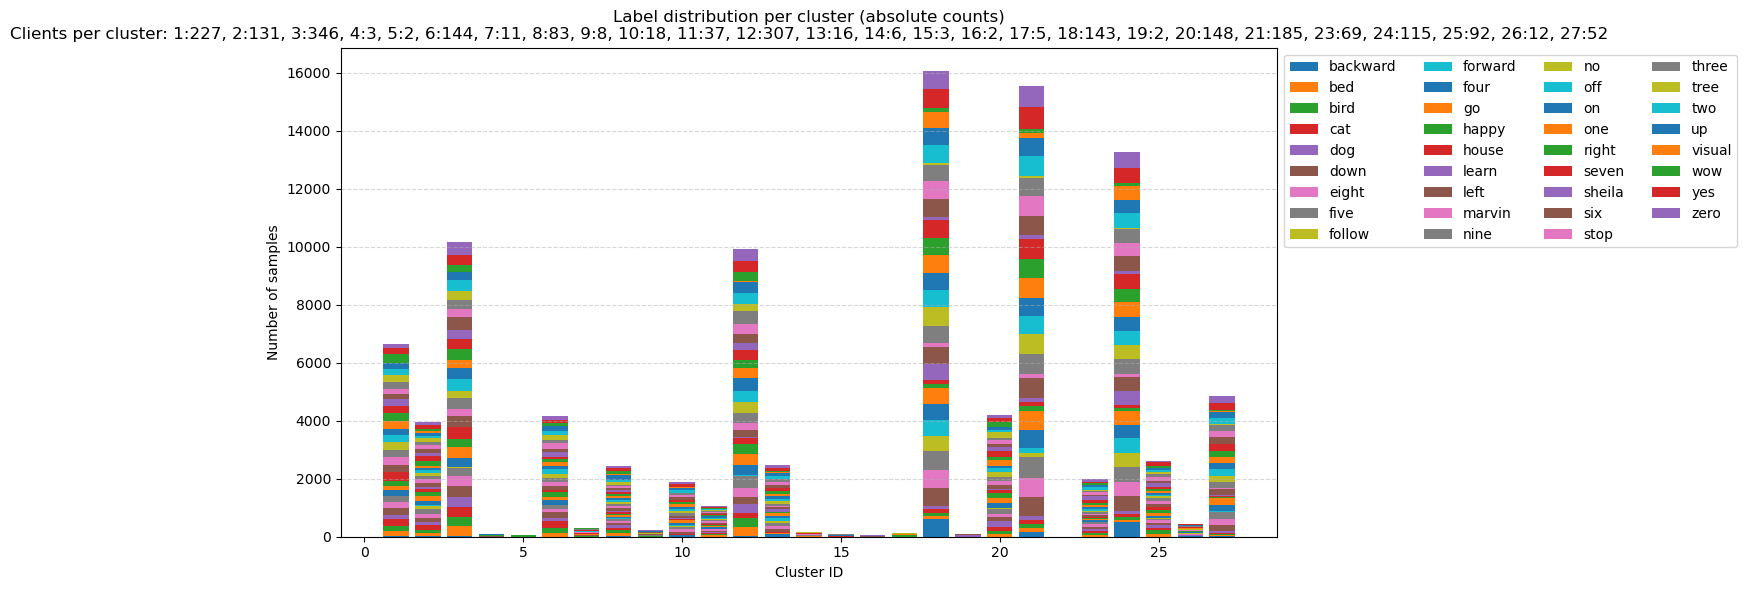

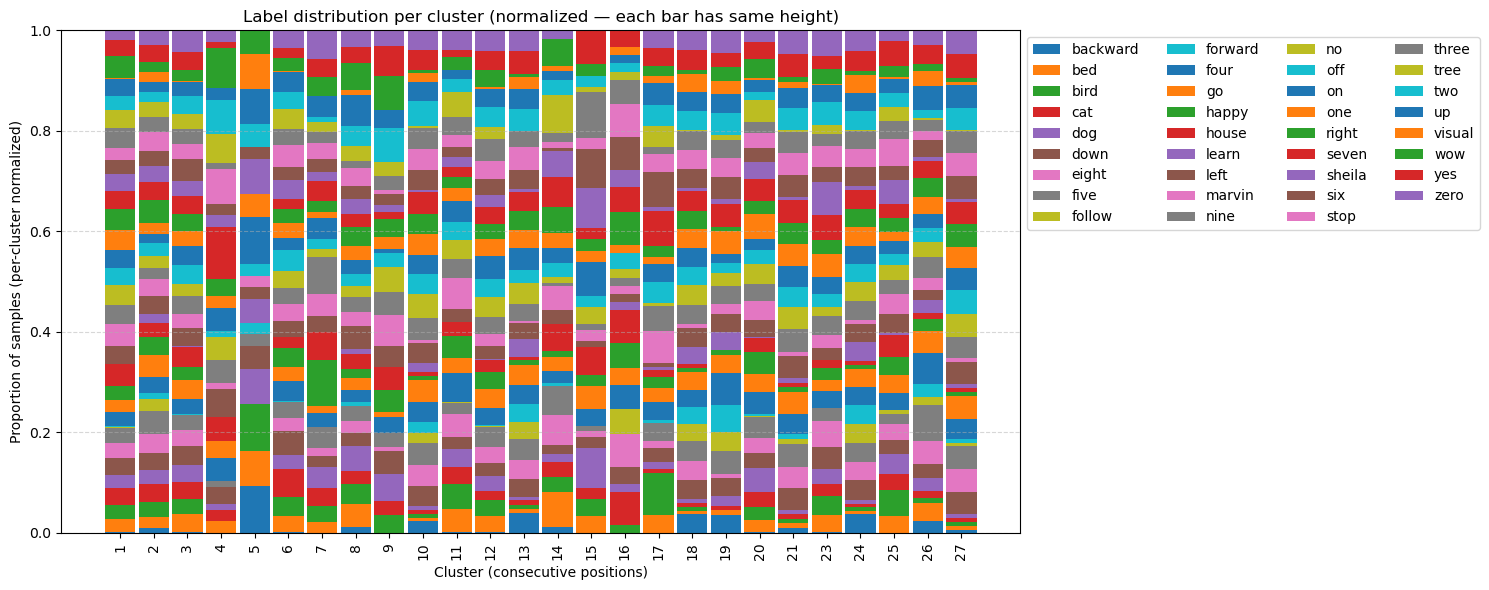

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("../benchmark/dataset/data/speech_client_data_mapping2")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df["split"] = split
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load cluster mapping
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

model_to_cluster = {}
for c in clusters:
    for m in c["models"]:
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients = pickle.load(f)

# Build client_id -> model
if isinstance(clients, dict):
    client_models = {int(v["id"]): v["model"] for v in clients.values()}
else:  # list-like
    client_models = {int(v["id"]): v["model"] for v in clients}

# Selected clients = those in CSVs
selected_clients = set(df["client_id"].unique())

# Build client_id -> cluster_id
client_to_cluster = {}
for cid in selected_clients:
    model = client_models[cid]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} (client {cid}) not found in clusters.json")
    client_to_cluster[cid] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per cluster
# -----------------------------
cluster_label_counts = defaultdict(Counter)
cluster_clients = defaultdict(set)

for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    clus = client_to_cluster[cid]
    cluster_label_counts[clus][lab] += 1
    cluster_clients[clus].add(cid)

# All labels sorted for deterministic stacking
all_labels = sorted(df["label_name"].unique())

# -----------------------------
# Build DataFrame (clusters x labels)
# -----------------------------
clusters_sorted = sorted(cluster_label_counts.keys())
mat = []
for clus in clusters_sorted:
    counts = [cluster_label_counts[clus][lab] for lab in all_labels]
    mat.append(counts)
mat = pd.DataFrame(mat, index=clusters_sorted, columns=all_labels)

# -----------------------------
# 1) Absolute stacked bar chart
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat[lab].values
    ax.bar(clusters_sorted, vals, bottom=bottom, label=lab, width=0.8)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Number of samples")
ax.set_title("Label distribution per cluster (absolute counts)\nClients per cluster: " +
             ", ".join(f"{c}:{len(cluster_clients[c])}" for c in clusters_sorted))
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Normalized stacked bar chart (all bars same total height)
# -----------------------------
# Normalize each cluster row to sum==1 (if a cluster has zero total, keep zeros)
row_sums = mat.sum(axis=1).replace(0, 1)   # avoid division by zero
mat_norm = mat.div(row_sums, axis=0)

fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat_norm[lab].values
    ax.bar(range(len(clusters_sorted)), vals, bottom=bottom, label=lab, width=0.9)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

# x ticks are consecutive indices; label them with cluster ids for reference
ax.set_xticks(range(len(clusters_sorted)))
ax.set_xticklabels(clusters_sorted, rotation=90)

ax.set_xlabel("Cluster (consecutive positions)")
ax.set_ylabel("Proportion of samples (per-cluster normalized)")
ax.set_title("Label distribution per cluster (normalized — each bar has same height)")
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

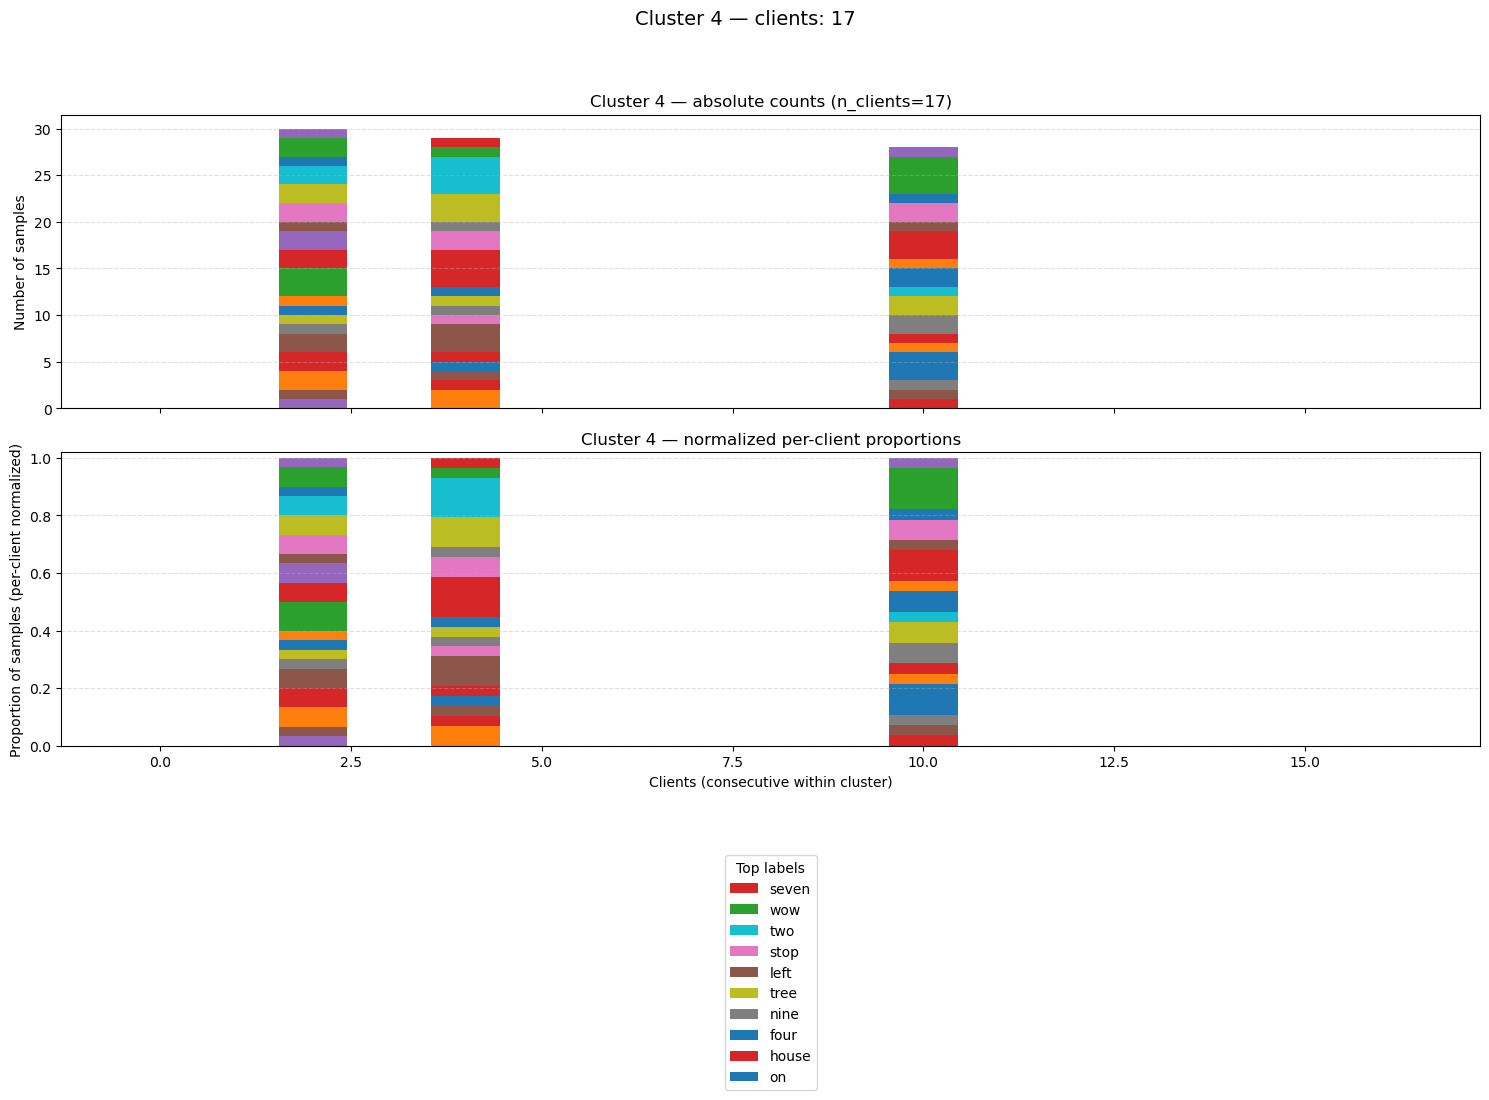

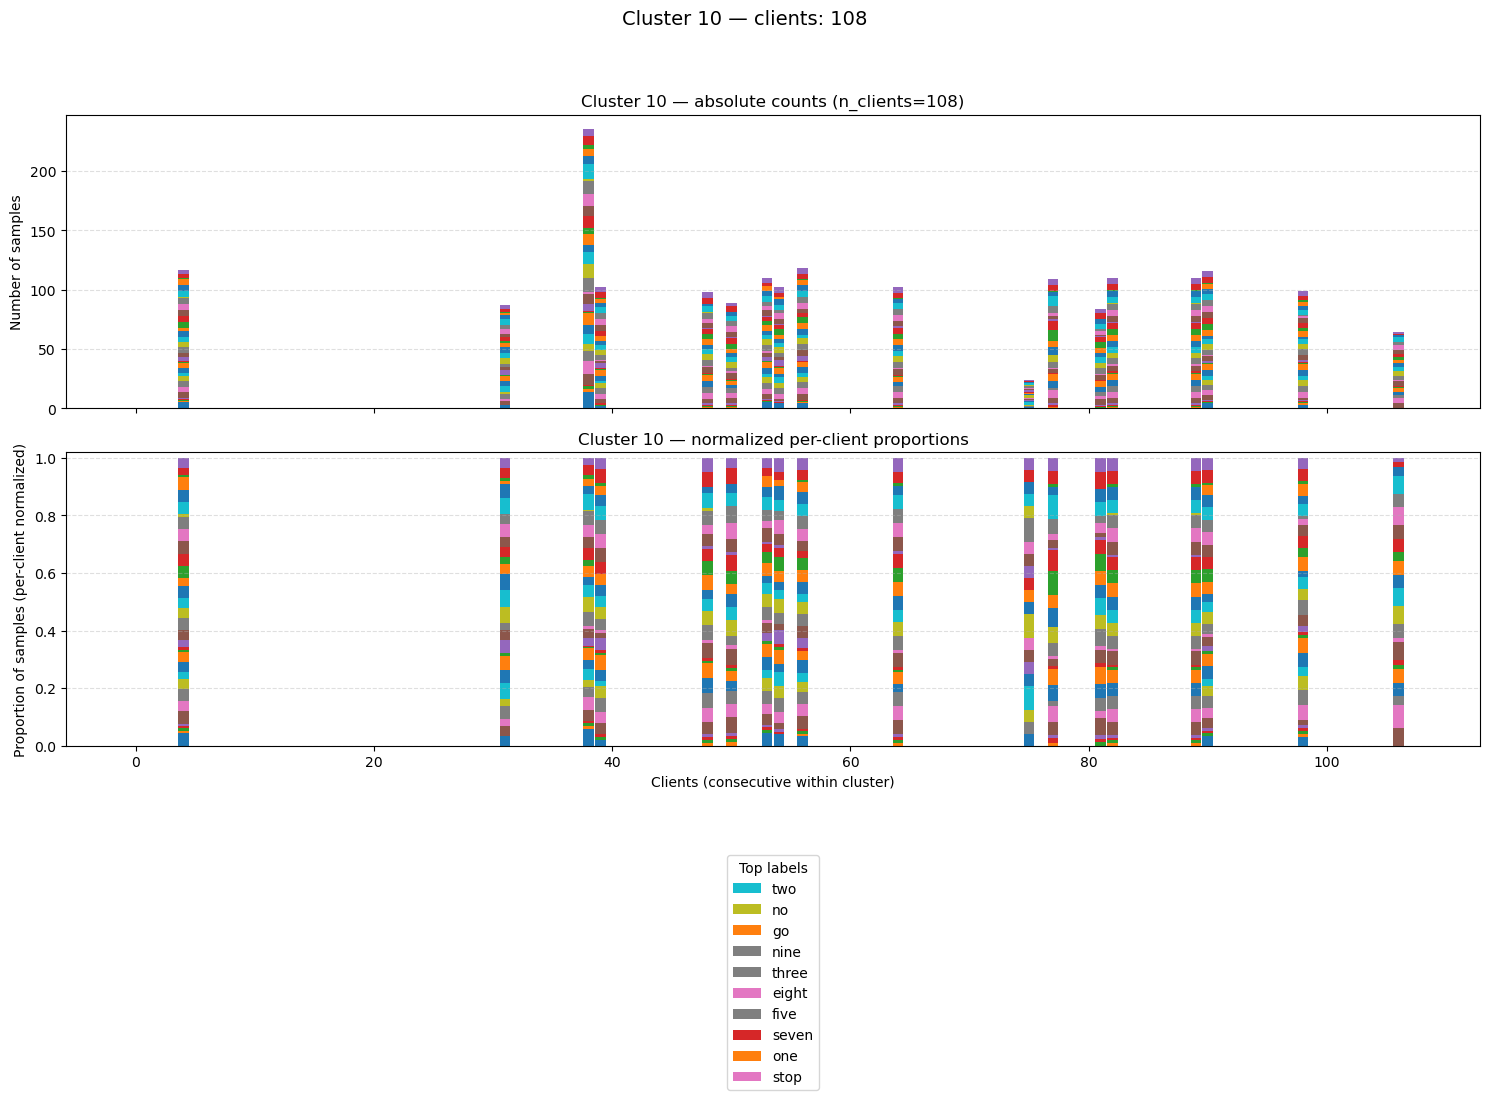

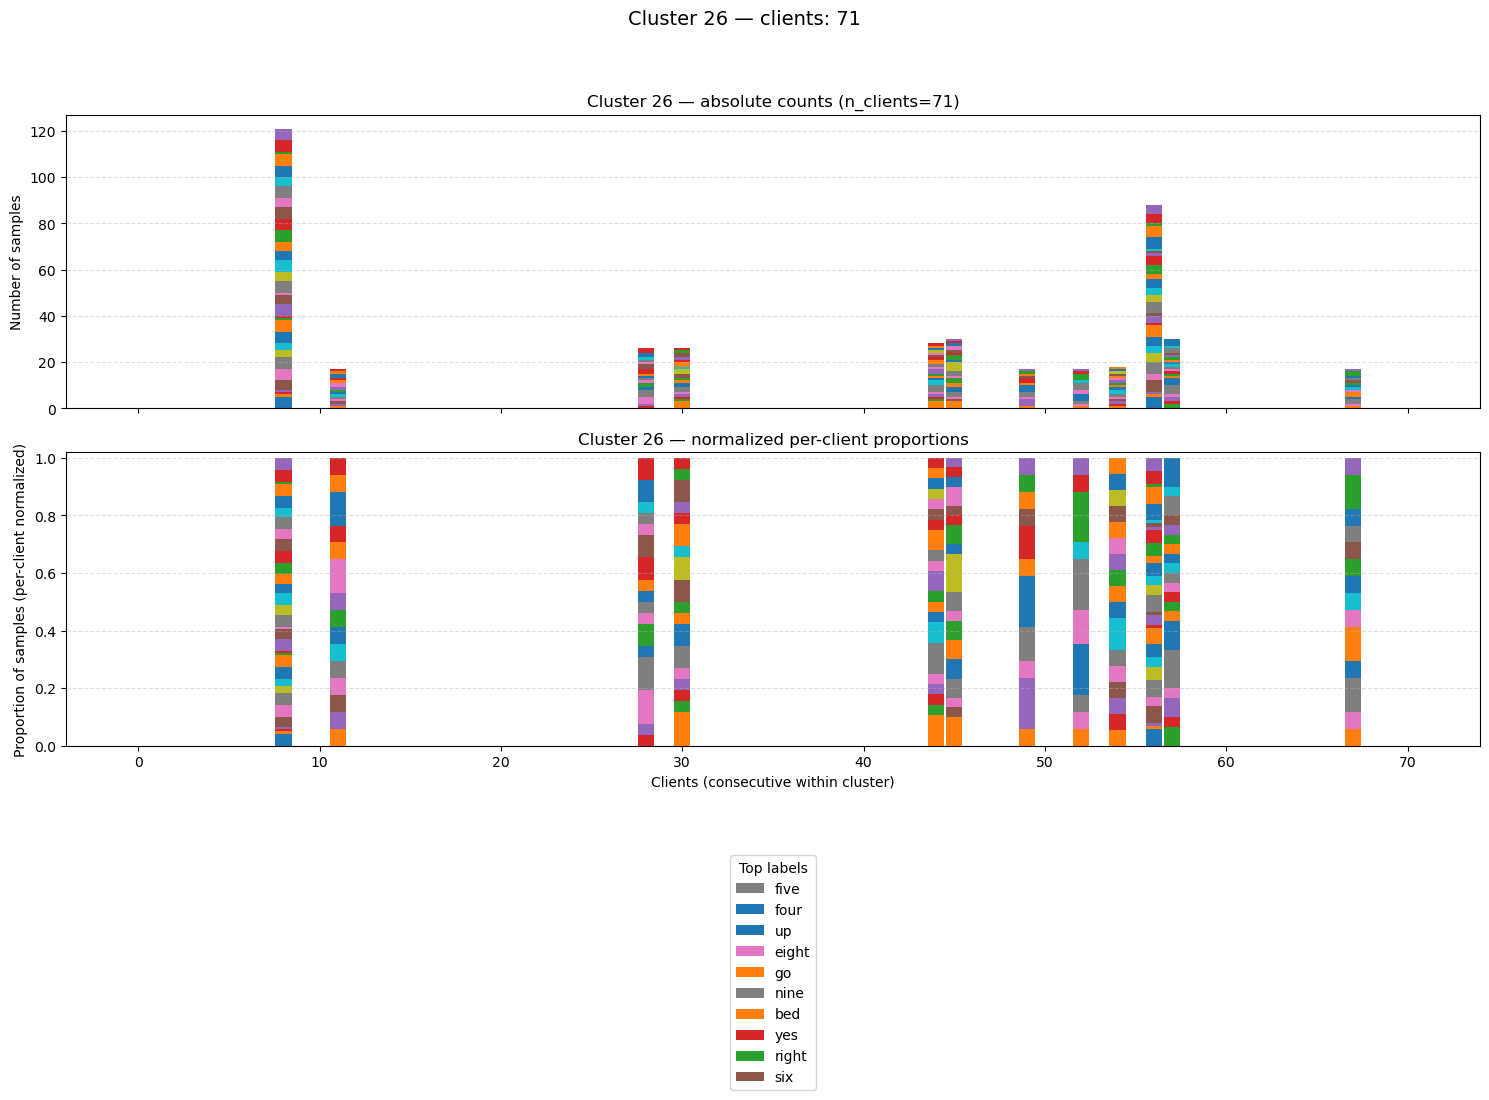

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("../benchmark/dataset/data/speech_client_data_mapping2")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

TARGET_CLUSTERS = [4, 10, 26]

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load clusters and clients
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)
model_to_cluster = {}
for c in clusters:
    for m in c.get("models", []):
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

entries.sort(key=lambda t: t[0])
N = int(df["client_id"].max()) + 1
new2old = {i: entries[i][0] for i in range(N)}
oldid_to_model = {old: model for (old, model) in entries}

client_to_cluster = {}
for new_id in range(N):
    model = oldid_to_model[new2old[new_id]]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} not in clusters.json")
    client_to_cluster[new_id] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per client
# -----------------------------
client_label_counts = defaultdict(Counter)
for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    client_label_counts[cid][lab] += 1

# -----------------------------
# Plot for target clusters (absolute above, normalized below)
# -----------------------------
labels = sorted(df["label_name"].unique())

for target_cluster in TARGET_CLUSTERS:
    # clients belonging to this cluster (consecutive index 0..M-1 used for plotting)
    cids = [cid for cid, clus in client_to_cluster.items() if clus == target_cluster]
    if not cids:
        print(f"No clients found for cluster {target_cluster}")
        continue

    # Build dataframe: rows = clients (consecutive index), cols = labels (absolute counts)
    mat_abs = []
    for cid in cids:
        mat_abs.append([client_label_counts[cid][lab] for lab in labels])
    mat_abs = pd.DataFrame(mat_abs, index=range(len(cids)), columns=labels)

    # Prepare normalized matrix: each row normalized to sum 1 (avoid division by zero)
    row_sums = mat_abs.sum(axis=1).replace(0, 1)  # keep zeros as zeros after division
    mat_norm = mat_abs.div(row_sums, axis=0)

    # Plot stacked vertically: absolute (top), normalized (bottom)
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(15, 12), sharex=True,
                                         gridspec_kw={'height_ratios': [1, 1]})

    # --- Top: Absolute stacked bar chart ---
    bottom = None
    for lab in labels:
        vals = mat_abs[lab].values
        ax_top.bar(mat_abs.index, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_top.set_ylabel("Number of samples")
    ax_top.set_title(f"Cluster {target_cluster} — absolute counts (n_clients={len(cids)})")
    ax_top.grid(axis="y", linestyle="--", alpha=0.4)

    # --- Bottom: Normalized stacked bar chart (each client bar sums to 1) ---
    bottom = None
    x = list(range(len(cids)))
    for lab in labels:
        vals = mat_norm[lab].values
        ax_bot.bar(x, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_bot.set_xlabel("Clients (consecutive within cluster)")
    ax_bot.set_ylabel("Proportion of samples (per-client normalized)")
    ax_bot.set_ylim(0, 1.02)
    ax_bot.set_title(f"Cluster {target_cluster} — normalized per-client proportions")
    ax_bot.grid(axis="y", linestyle="--", alpha=0.4)

    # Legend handling: show only if label count small, else show top-10 labels by count
    if len(labels) <= 20:
        # show full legend below the bottom plot
        ax_bot.legend(ncol=4, bbox_to_anchor=(0.5, -0.35), loc="upper center")
    else:
        cluster_label_totals = mat_abs.sum(axis=0).sort_values(ascending=False)
        topk = cluster_label_totals.index[:10].tolist()
        handles, lablist = ax_bot.get_legend_handles_labels()
        lbl2h = dict(zip(lablist, handles))
        sel_handles = [lbl2h[l] for l in topk if l in lbl2h]
        if sel_handles:
            ax_bot.legend(sel_handles, topk, title="Top labels", bbox_to_anchor=(0.5, -0.35), loc="upper center")

    plt.suptitle(f"Cluster {target_cluster} — clients: {len(cids)}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Detected max client id in CSVs => using N = 12640 clients (ids 0..12639).


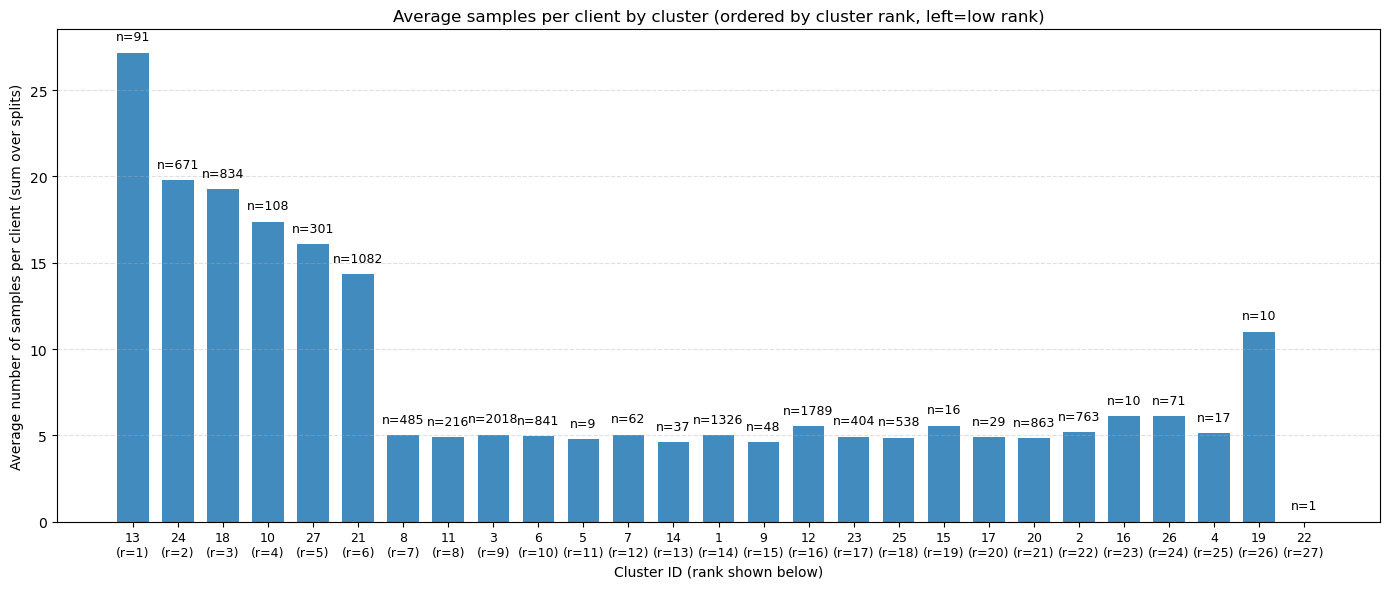

 cluster  rank  n_clients  avg_samples_per_client
      13   1.0         91               27.164835
      24   2.0        671               19.780924
      18   3.0        834               19.254197
      10   4.0        108               17.379630
      27   5.0        301               16.069767
      21   6.0       1082               14.353974
       8   7.0        485                5.018557
      11   8.0        216                4.888889
       3   9.0       2018                5.036174
       6  10.0        841                4.950059
       5  11.0          9                4.777778
       7  12.0         62                5.048387
      14  13.0         37                4.621622
       1  14.0       1326                5.001508
       9  15.0         48                4.604167
      12  16.0       1789                5.547792
      23  17.0        404                4.930693
      25  18.0        538                4.869888
      15  19.0         16                5.562500


In [4]:
import json
import pickle
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("../benchmark/dataset/data/speech_client_data_mapping2")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# -----------------------------
# Load CSVs and compute per-client total counts
# -----------------------------
dfs = []
for p in CSV_FILES.values():
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")
    dfs.append(pd.read_csv(p))
df = pd.concat(dfs, ignore_index=True)

# Total samples per client across all splits (include clients with zero later)
per_client_counts = df.groupby("client_id").size().to_dict()   # client_id -> count

# Determine N (assume CSVs contain new IDs 0..N-1; N = max_id+1)
N = int(df["client_id"].max()) + 1
print(f"Detected max client id in CSVs => using N = {N} clients (ids 0..{N-1}).")

# Build a dense vector of counts length N (clients with no rows -> 0)
counts_arr = np.zeros(N, dtype=int)
for cid, cnt in per_client_counts.items():
    counts_arr[int(cid)] = int(cnt)

# -----------------------------
# Load clients.pkl and clusters.json and build mapping new_id -> cluster & cluster ranks
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

# model -> cluster_id mapping (ensure uniqueness) and cluster_id->rank
model_to_cluster = {}
cluster_rank = {}
for c in clusters:
    cid = int(c["id"])
    cluster_rank[cid] = float(c.get("rank", 0.0))
    for m in c.get("models", []):
        if m in model_to_cluster and model_to_cluster[m] != cid:
            raise RuntimeError(f"Model '{m}' appears in multiple clusters ({model_to_cluster[m]} and {cid})")
        model_to_cluster[m] = cid

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

# Build sorted entries (old_id, model) in ascending old_id order (same convention used when generating CSVs)
entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

entries.sort(key=lambda t: t[0])

if len(entries) < N:
    raise RuntimeError(f"clients.pkl has only {len(entries)} entries but we require first N={N}. Aborting.")

# new_id -> old_id mapping (we assume the same remapping as used in the partitioner)
new2old = {i: entries[i][0] for i in range(N)}
old2model = {old: model for (old, model) in entries}

# Build new_id -> cluster mapping (raise if model missing from clusters.json)
client_to_cluster = {}
for new_id in range(N):
    old_id = new2old[new_id]
    model = old2model.get(old_id)
    if model is None:
        raise RuntimeError(f"Old client id {old_id} not found in clients.pkl entries")
    if model not in model_to_cluster:
        raise RuntimeError(f"Model '{model}' (old_id={old_id}, new_id={new_id}) not found in clusters.json")
    client_to_cluster[new_id] = int(model_to_cluster[model])

# -----------------------------
# Aggregate: compute average samples per client for each cluster
# -----------------------------
cluster_to_client_ids = defaultdict(list)
for new_id, cluster_id in client_to_cluster.items():
    cluster_to_client_ids[cluster_id].append(new_id)

# Order clusters by their rank (ascending: rank=1 leftmost, higher ranks to the right).
# If a cluster has no rank entry, use 0.0 by default.
clusters_present = list(cluster_to_client_ids.keys())
clusters_sorted = sorted(clusters_present, key=lambda k: cluster_rank.get(k, 0.0))

cluster_means = []
cluster_counts = []
cluster_ranks_list = []
for k in clusters_sorted:
    cids = cluster_to_client_ids[k]
    arr = counts_arr[cids]                # vector of counts for clients in this cluster (includes zeros)
    mean = float(arr.mean())
    cluster_means.append(mean)
    cluster_counts.append(len(cids))
    cluster_ranks_list.append(cluster_rank.get(k, 0.0))

# -----------------------------
# Plot bar chart: avg samples per client per cluster (ordered by rank)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(clusters_sorted))
ax.bar(x, cluster_means, width=0.7, color="tab:blue", alpha=0.85)
ax.set_xticks(x)

# show cluster id and rank in xtick labels for clarity
xtick_labels = [f"{int(k)}\n(r={cluster_rank.get(k,0):.2g})" for k in clusters_sorted]
ax.set_xticklabels(xtick_labels, rotation=0, fontsize=9)

ax.set_xlabel("Cluster ID (rank shown below)")
ax.set_ylabel("Average number of samples per client (sum over splits)")
ax.set_title("Average samples per client by cluster (ordered by cluster rank, left=low rank)")

# annotate with number of clients above each bar
max_mean = max(cluster_means) if cluster_means else 1.0
for xi, mean, cnt in zip(x, cluster_means, cluster_counts):
    ax.text(xi, mean + max_mean * 0.02, f"n={cnt}", ha="center", va="bottom", fontsize=9)

ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# -----------------------------
# Also print a small table for numeric inspection (ordered by rank)
# -----------------------------
tbl = pd.DataFrame({
    "cluster": clusters_sorted,
    "rank": cluster_ranks_list,
    "n_clients": cluster_counts,
    "avg_samples_per_client": cluster_means,
})
print(tbl.sort_values("rank").to_string(index=False))

In [5]:

from pathlib import Path
import numpy as np
import pandas as pd
import json, pickle

# Simple, intuitive similarity metrics
# - Global centroid cosine: average cosine similarity of each client's normalized label histogram to the global centroid
# - Within-rank cosine: average cosine similarity to the centroid of its assigned rank
# - Across-rank centroid cosine: average cosine similarity between rank centroids (pairwise average)

try:
    _ = label_vectors  # already in memory from Cell 1
    _ = assignment_ranks
    vectors = label_vectors.copy()
    ranks = assignment_ranks.copy()
    print("Using in-memory label_vectors and assignment_ranks.")
except NameError:
    print("Reloading from disk to compute metrics…")
    project_root = Path.cwd().parent
    train_csv_path = project_root / "benchmark/dataset/data/speech_client_data_mapping2/train.csv"
    clients_path = project_root / "benchmark/dataset/data/clients.pkl"
    clusters_path = project_root / "thirdparty/bliss/clusters.json"

    # Load mapping CSV and compute normalized per-client label histograms
    df = pd.read_csv(train_csv_path)
    group_sizes = df.groupby("client_id").size()
    label_counts = (
        df.groupby(["client_id", "label_id"]).size().unstack(fill_value=0).astype(float)
    )
    label_counts = label_counts.reindex(group_sizes.index, fill_value=0.0)
    vectors = label_counts.to_numpy()
    vectors = vectors + 1e-8
    vectors = vectors / vectors.sum(axis=1, keepdims=True)
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    vectors = vectors / np.clip(norms, 1e-12, None)
    group_ids = group_sizes.index.to_numpy()

    # Map device client_id -> model -> rank
    with open(clients_path, "rb") as f:
        clients_obj = pickle.load(f)
    with open(clusters_path, "r") as f:
        clusters = json.load(f)
    model_to_rank = {}
    for c in clusters:
        r = c.get("rank")
        if r is None: continue
        for m in c.get("models", []) or []:
            if not m: continue
            model_to_rank[m.strip()] = int(r)
            model_to_rank[m.strip().lower()] = int(r)
    id_to_model = {}
    if isinstance(clients_obj, dict):
        for v in clients_obj.values():
            id_to_model[int(v.get("id"))] = v.get("model", "")
    else:
        for v in clients_obj:
            id_to_model[int(v.get("id"))] = v.get("model", "")
    ranks = np.zeros(len(group_ids), dtype=int)
    for i, cid in enumerate(group_ids):
        model = (id_to_model.get(int(cid)) or "").strip()
        rk = model_to_rank.get(model, model_to_rank.get(model.lower(), 0))
        if not rk:
            raise RuntimeError(f"No rank for client_id {cid} (model={model})")
        ranks[i] = rk

# Global centroid metric
global_center = vectors.mean(axis=0)
ng = np.linalg.norm(global_center)
if ng > 1e-12:
    global_center = global_center / ng
cos_global = (vectors @ global_center)

# Per-rank centroids and within-rank metric
unique_ranks = np.unique(ranks)
centroids = {}
for r in unique_ranks:
    idx = (ranks == r)
    if not np.any(idx):
        continue
    c = vectors[idx].mean(axis=0)
    n = np.linalg.norm(c)
    if n > 1e-12:
        c = c / n
    centroids[r] = c
within_vals = []
for i in range(vectors.shape[0]):
    c = centroids.get(int(ranks[i]))
    if c is None: continue
    within_vals.append(float(vectors[i].dot(c)))
within_vals = np.array(within_vals, dtype=float)

# Across-rank centroid similarity (pairwise average)
centroid_list = [centroids[r] for r in sorted(centroids.keys())]
if len(centroid_list) >= 2:
    C = np.stack(centroid_list)
    K = C.shape[0]
    sim_mat = C @ C.T
    iu = np.triu_indices(K, k=1)
    across_centroid_vals = sim_mat[iu]
else:
    across_centroid_vals = np.array([np.nan])

print("Simple label-similarity metrics")
print(f"- Groups: {vectors.shape[0]}, Labels: {vectors.shape[1]}, Active ranks: {len(centroids)}")
print(f"- Global centroid cosine: mean={cos_global.mean():.4f}, std={cos_global.std(ddof=0):.4f}")
print(f"- Within-rank cosine:    mean={within_vals.mean():.4f}, std={within_vals.std(ddof=0):.4f}")
print(f"- Across-rank centroid cosine (pairwise): mean={np.nanmean(across_centroid_vals):.4f}, std={np.nanstd(across_centroid_vals, ddof=0):.4f}")


# Also report client-to-client cosine similarities (pairwise means)
# Using sum-vector identity so it scales to large N without O(N^2) memory.
try:
    X = label_vectors.copy()  # rows are unit L2 norm
    rks = assignment_ranks.copy()
except NameError:
    # Fallback if not in memory: rebuild from saved mapping
    project_root = Path.cwd().parent
    df = pd.read_csv(project_root / 'benchmark/dataset/data/speech_client_data_mapping2/train.csv')
    group_sizes = df.groupby('client_id').size()
    label_counts = df.groupby(['client_id','label_id']).size().unstack(fill_value=0).astype(float)
    label_counts = label_counts.reindex(group_sizes.index, fill_value=0.0)
    X = label_counts.to_numpy()
    X = X + 1e-8
    X = X / X.sum(axis=1, keepdims=True)
    X = X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)
    # ranks via current assignment: we cannot reconstruct easily without cell 1,
    # so treat all as a single cluster in fallback
    rks = np.ones(X.shape[0], dtype=int)

n = X.shape[0]
V = X.sum(axis=0)
num_pairs_global = n * (n - 1) / 2.0
sum_pair_global = 0.5 * (float(V @ V) - n)
mean_pair_global = sum_pair_global / num_pairs_global if num_pairs_global > 0 else float('nan')

# Within- and across-rank (rank=cluster) client-to-client cosine
within_sum = 0.0
within_pairs = 0.0
per_cluster_means = []
for r in np.unique(rks):
    idx = (rks == r)
    k = int(idx.sum())
    if k < 2:
        continue
    Vr = X[idx].sum(axis=0)
    pairs_r = k * (k - 1) / 2.0
    sum_r = 0.5 * (float(Vr @ Vr) - k)
    within_sum += sum_r
    within_pairs += pairs_r
    per_cluster_means.append(sum_r / pairs_r)

mean_within_weighted = within_sum / within_pairs if within_pairs > 0 else float('nan')
mean_within_unweighted = float(np.mean(per_cluster_means)) if per_cluster_means else float('nan')
across_pairs = num_pairs_global - within_pairs
across_sum = sum_pair_global - within_sum
mean_across = across_sum / across_pairs if across_pairs > 0 else float('nan')

# Build X (unit L2) and rks (rank per client) robustly
try:
    # Preferred: use in-memory vectors (per-group histograms) and assignment ranks
    X = label_vectors.copy()
    rks = assignment_ranks.copy()
    # X rows correspond one-to-one to assigned clients (each group mapped to exactly one client)
except NameError:
    # Fallback: recompute per-client vectors from saved mapping and ranks from clients.pkl + clusters.json
    from pathlib import Path
    import json, pickle
    project_root = Path.cwd().parent
    df = pd.read_csv(project_root / 'benchmark/dataset/data/speech_client_data_mapping2/train.csv')
    # per-client normalized histograms
    gsz = df.groupby('client_id').size()
    counts = df.groupby(['client_id','label_id']).size().unstack(fill_value=0).astype(float)
    counts = counts.reindex(gsz.index, fill_value=0.0)
    X = counts.to_numpy()
    X = X + 1e-8
    X = X / X.sum(axis=1, keepdims=True)
    X = X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)
    # ranks via model->rank
    with open(project_root / 'benchmark/dataset/data/clients.pkl', 'rb') as f:
        clients_obj = pickle.load(f)
    with open(project_root / 'thirdparty/bliss/clusters.json', 'r') as f:
        clusters = json.load(f)
    model_to_rank = {}
    for c in clusters:
        r = c.get('rank')
        if r is None: continue
        for m in c.get('models', []) or []:
            if not m: continue
            model_to_rank[m.strip()] = int(r)
            model_to_rank[m.strip().lower()] = int(r)
    id_to_model = {}
    if isinstance(clients_obj, dict):
        for v in clients_obj.values():
            id_to_model[int(v.get('id'))] = v.get('model','')
    else:
        for v in clients_obj:
            id_to_model[int(v.get('id'))] = v.get('model','')
    cids_sorted = gsz.index.to_numpy()
    rks_list = []
    missing = 0
    for cid in cids_sorted:
        model = (id_to_model.get(int(cid)) or '').strip()
        rk = model_to_rank.get(model, model_to_rank.get(model.lower()))
        if rk is None:
            missing += 1
            rk = 0
        rks_list.append(int(rk))
    if missing:
        print(f'Warning: {missing} clients missing rank; excluded from within/across splits.')
    rks = np.array(rks_list, dtype=int)

# Remove clients without rank if any
mask = rks > 0
if not mask.all():
    X = X[mask]
    rks = rks[mask]

# Global pairwise cosine mean via sum-vector identity
n = X.shape[0]
V = X.sum(axis=0)
num_pairs_global = n * (n - 1) / 2.0
sum_pair_global = 0.5 * (float(V @ V) - n)
mean_pair_global = sum_pair_global / num_pairs_global if num_pairs_global > 0 else float('nan')

# Within- and across-cluster (ranks are clusters) client-to-client cosine
within_sum = 0.0
within_pairs = 0.0
per_cluster_means = []
for r in np.unique(rks):
    idx = (rks == r)
    k = int(idx.sum())
    if k < 2:
        continue
    Vr = X[idx].sum(axis=0)
    pairs_r = k * (k - 1) / 2.0
    sum_r = 0.5 * (float(Vr @ Vr) - k)
    within_sum += sum_r
    within_pairs += pairs_r
    per_cluster_means.append(sum_r / pairs_r)

mean_within_weighted = within_sum / within_pairs if within_pairs > 0 else float('nan')
mean_within_unweighted = float(np.mean(per_cluster_means)) if per_cluster_means else float('nan')
across_pairs = num_pairs_global - within_pairs
across_sum = sum_pair_global - within_sum
mean_across = across_sum / across_pairs if across_pairs > 0 else float('nan')

print('Client label-distribution similarity (cosine)')
print(f'- Global client-to-client cosine (all pairs): mean={mean_pair_global:.4f}')
print(f'- Within-cluster client-to-client cosine:    mean_weighted={mean_within_weighted:.4f}, mean_unweighted={mean_within_unweighted:.4f}')
print(f'- Across-cluster client-to-client cosine:    mean={mean_across:.4f}')


Using in-memory label_vectors and assignment_ranks.
Simple label-similarity metrics
- Groups: 2167, Labels: 35, Active ranks: 26
- Global centroid cosine: mean=0.7388, std=0.0936
- Within-rank cosine:    mean=0.7821, std=0.1112
- Across-rank centroid cosine (pairwise): mean=0.7771, std=0.1215
Client label-distribution similarity (cosine)
- Global client-to-client cosine (all pairs): mean=0.5455
- Within-cluster client-to-client cosine:    mean_weighted=0.5854, mean_unweighted=0.6271
- Across-cluster client-to-client cosine:    mean=0.5417
